```markdown<img src="../../../docs/images/DSPy8.png" alt="DSPy7 图片" height="150"/>```

# 在 DSPy 中使用多阶段指令提案和优化（MIPRO）[![colab-badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stanfordnlp/dspy/blob/main/examples/qa/hotpot/hotpotqa_with_MIPRO.ipynb)

### 常见问题 🙋#### 1) MIPRO是如何工作的？在高层次上，MIPRO程序优化器首先通过提出候选的少样本示例集和每个提示的指令来工作，然后在指定数量的试验中对这些少样本示例集和指令进行优化作为超参数。每次试验，优化器会在训练集上评估不同组合的提示，从而学习哪些组合能够获得最佳性能。#### 2) 运行MIPRO会给我带来多少成本？请注意，这个笔记本是免费运行的，因为所有LM调用都已被缓存。然而，当在自己的程序上使用优化器时，以下是对任务模型调用和提示模型调用的上限的分解：- **任务模型调用**：MIPRO最多进行O(TxPxM)次任务模型调用，其中T是试验次数，P是程序中提示的数量，M是训练集的大小。这是因为模型在每次试验中都在训练集上评估程序。实际上，这应该会更低，因为MIPRO会尽早调整不良试验（即，如果性能不佳，它可能在运行前100个左右的示例后停止试验）。- **提示模型调用**：MIPRO最多进行N*P+10次提示模型调用，其中N是为每个提示生成的指令/少样本示例集候选的数量，P是程序中提示的数量。额外的10次调用来自生成训练集数据摘要，我们在元提示中使用它来创建更好的指令。#### 3) 我应该如何配置超参数？我们尚未对MIPRO进行完整的超参数扫描，但基于初步实验，我们建议以下操作：- __试验次数__：大约20-30次试验后可以看到收益。然而，100-200次试验可以帮助增加额外的边际收益。- __n__：这个超参数控制要生成的候选提示和少样本示例集的数量，以进行优化。随着更多的试验和更少的要优化的提示，我们可以将n设置得更高，因为我们有更多的试验来探索不同的提示组合。如果您的程序有2-3个模块，并且`num_trials=30`，我们建议设置为~`n=10`。如果n更高（比如`n=100`），那么我们可以设置为更高的~`n=15`。如果您的程序只有1个模块，并且将程序保持为0-shot（即没有少样本示例），那么`num_trials`应设置为等于`n`，因为每次试验可以探索一个新的指令。- __训练集大小__：建议在200到500个训练示例之间。增加训练集大小可以帮助防止过拟合，但会增加运行成本。#### 4) 如果我想要降低成本，我该怎么办？您可以根据需要更新超参数，例如使用较小的训练集、减少试验次数或使用模块较少的程序。另一种策略是使用更便宜的任务模型进行优化（例如本地托管的Llama-2），因为初步实验表明，针对较小模型优化的提示也能很好地转移到较大模型上。

### 0] 设置

首先，如果尚未安装__DSPy__，我们将安装它。我们还将加载此任务的缓存请求，以便在此笔记本中无需实际调用任何语言模型。我们还将加载来自Hugging Face的预优化程序，以便稍后进行检查。

In [1]:
%load_ext autoreload%autoreload 2import sysimport ostry: # 当在谷歌Colab上时，让我们克隆笔记本以便下载缓存。    import google.colab    repo_path = 'dspy'    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_pathexcept:    repo_path = '.'if repo_path not in sys.path:    sys.path.append(repo_path)import pkg_resources # 如果未安装该包，则安装该包if not "dspy-ai" in {pkg.key for pkg in pkg_resources.working_set}:    !pip install -U pip    !pip install dspy-ai    !pip install openai~=0.28.1    !pip install -e $repo_path    !pip install --upgrade cloudpickle==3.0.0from huggingface_hub import hf_hub_downloadimport zipfileimport osrepo_id = 'kopsahlong/DSPy_MIPRO_notebook_cache'cache_file_path = hf_hub_download(repo_id=repo_id, filename='MIPRO_notebook_cache.zip')compiled_program_file_path = hf_hub_download(repo_id=repo_id, filename='compiled_program.pickle')with zipfile.ZipFile(cache_file_path, 'r') as zip_ref:    zip_ref.extractall(".")os.environ["DSP_NOTEBOOK_CACHEDIR"] = f"{os.getcwd()}/MIPRO_notebook_cache"import dspy

我们还将指定__提示语言模型__（在本例中为GPT 3.5），__任务语言模型__（Llama 13B）以及我们将用于任务的检索模型（一个HotPotQA多跳检索任务）。

In [2]:
import openai### 注意：如果您想在没有缓存的情况下运行此代码，可以删除以下行以配置您的 OPEN AI 密钥 #### os.environ['OPENAI_API_KEY'] = "TODO: 在此处添加您的 OPEN AI 密钥"# openai.api_key = os.environ.get('OPENAI_API_KEY')# openai.api_base = "https://api.openai.com/v1"prompt_model_name = "gpt-3.5-turbo-1106"task_model_name = "meta-llama/Llama-2-13b-chat-hf"colbert_v2_endpoint = "http://20.102.90.50:2017/wiki17_abstracts"prompt_model = dspy.OpenAI(model=prompt_model_name, max_tokens=150)  # 使用指定的模型名称和最大标记数创建 OpenAI 模型task_model = dspy.HFClientTGI(model=task_model_name, port=[7140, 7141, 7142, 7143], max_tokens=150)  # 使用指定的模型名称、端口和最大标记数创建 HFClientTGI 模型colbertv2 = dspy.ColBERTv2(url=colbert_v2_endpoint)  # 使用指定的端点 URL 创建 ColBERTv2 模型dspy.settings.configure(rm=colbertv2, lm=task_model)  # 配置设置，将 ColBERTv2 模型用作 rm，将 HFClientTGI 模型用作 lm

### 1] 定义任务

在这里，我们将定义我们想要运行的程序，这是一个多跳[...]（我们可以说它受到某篇论文的启发）。我们还加载数据，并定义我们想要如何评估这个任务。

In [3]:
import refrom dspy.evaluate import Evaluatefrom dspy.datasets import HotPotQAfrom dsp.utils import EMclass ReturnRankedDocuments(dspy.Signature):    """给定一个问题和一组段落，返回一个逗号分隔的数字列表，这些数字应按照回答问题的帮助程度排序，最有帮助的段落编号排在第一位，最不有帮助的排在最后。"""    question = dspy.InputField(desc="我们试图回答的问题。")    context = dspy.InputField(desc="潜在相关段落的列表。")    ranking = dspy.OutputField(desc="一个逗号分隔的数字列表，对应段落索引，按照回答问题的帮助程度降序排列。")class RankingMultiHop(dspy.Module):    def __init__(self, hops, num_passages_to_retrieve, max_passages_in_context):        super().__init__()        self.hops = hops        self.num_passages_to_retrieve = num_passages_to_retrieve        self.max_passages_in_context = max_passages_in_context        self.retrieve = dspy.Retrieve(k = self.num_passages_to_retrieve)        self.generate_query = dspy.ChainOfThought("context ,question->search_query")        self.generate_answer = dspy.ChainOfThought("context ,question->answer")        self.generate_ranking = dspy.ChainOfThought(ReturnRankedDocuments)    def forward(self,question):        context = []        full_context = []        top_context = []        max_passage_num = self.max_passages_in_context        for hop in range(self.hops):            # 获取新查询            query = self.generate_query(context = context, question = question).search_query            # 获取新段落            context = self.retrieve(query).passages            # 将这些新段落添加到之前的顶部上下文            full_context = top_context + context            # 获取最重要的索引，按排序            most_important_indices =  self.generate_ranking(question=question, context=full_context).ranking            indices = [int(num) for num in re.findall(r'\d+', most_important_indices)]            if len(indices) < max_passage_num:                indices = range(1,max_passage_num+1)            valid_indices = [index-1 for index in indices if index-1 < len(context)]            top_indices = sorted(valid_indices, key=lambda x: x)[:max_passage_num+1]            most_important_context_list = [context[idx] for idx in top_indices]            # 保存顶部上下文            top_context = most_important_context_list        return dspy.Prediction(context=context, answer=self.generate_answer(context = top_context , question = question).answer)program = RankingMultiHop(hops=4, num_passages_to_retrieve=5, max_passages_in_context=5)# 加载和配置数据集。TRAIN_SIZE = 500EVAL_SIZE = 500hotpot_dataset = HotPotQA(train_seed=1, eval_seed=2023, test_size=0)trainset = [x.with_inputs('question') for x in hotpot_dataset.train][:TRAIN_SIZE]devset = [x.with_inputs('question') for x in hotpot_dataset.dev][:EVAL_SIZE]# 设置指标NUM_THREADS = 10metric = dspy.evaluate.answer_exact_matchkwargs = dict(num_threads=NUM_THREADS, display_progress=True)evaluate = Evaluate(devset=devset, metric=metric, **kwargs)

/lfs/0/kristaoo/miniconda3/envs/dspy_test/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


### 2] 基准评估现在，我们将快速评估我们的基准程序，以便我们可以看到使用提示优化器的性能如何进行比较。我们应该在我们的训练集上看到大约__21.6%__的性能，以及在我们的开发集上看到__22.6%__的性能。

In [4]:
# 计算基准模型在训练集上的评分baseline_train_score = evaluate(program, devset=trainset)# 计算基准模型在验证集上的评分baseline_eval_score = evaluate(program, devset=devset)

Average Metric: 3 / 7  (42.9):   1%|          | 6/500 [00:00<00:43, 11.48it/s]

Average Metric: 108 / 500  (21.6): 100%|██████████| 500/500 [00:33<00:00, 14.99it/s]
/lfs/0/kristaoo/dspy/dspy/evaluate/evaluate.py:187: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


Average Metric: 108 / 500  (21.6%)


Average Metric: 113 / 500  (22.6): 100%|██████████| 500/500 [00:33<00:00, 14.78it/s]


Average Metric: 113 / 500  (22.6%)


### 3] 使用MIPRO进行优化

现在让我们进入这个笔记本中的关键方法 - 使用MIPRO优化我们的程序！

#### 3a] 编译程序首先，我们将获取我们优化过的程序。默认情况下，我们将`LOAD_PRECOMPILED_PROGRAM`设置为`True`，这样您就可以快速访问我们为您预编译的程序。但是，如果您希望自行优化，可以将`LOAD_PRECOMPILED_PROGRAM`设置为`False`（请注意，这将需要在上面的__设置__部分中添加您自己的LM API密钥）。MIPRO只需要一个度量、DSPy模块和训练集，就可以在您的任务上获得巨大的收益！您可以实例化一个MIPRO优化器并在只需两行代码中进行编译：```pythonteleprompter = BayesianSignatureOptimizer(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature)compiled_program = teleprompter.compile(program, trainset=trainset, num_trials=trials, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)```

In [5]:
import cloudpickle as picklefrom dspy.teleprompt import MIPROLOAD_PRECOMPILED_PROGRAM = True# 默认情况下，我们将加载预编译的程序if LOAD_PRECOMPILED_PROGRAM:    # 加载我们的预编译程序    with open(compiled_program_file_path, 'rb') as file:        # 从文件中加载数据        compiled_program = pickle.load(file)# 否则，如果需要，程序可以从头开始编译else:    # 定义超参数：    N = 10 # 我们将生成和优化的指令和少样本示例的数量    trials = 30 # 要运行的优化试验次数（我们将在每次试验中测试新的指令和少样本示例的组合）    temperature = 1.0 # 用于生成新指令的温度    # 编译    eval_kwargs = dict(num_threads=16, display_progress=True, display_table=0)    teleprompter = MIPRO(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature, verbose=True)    compiled_program = teleprompter.compile(program, trainset=trainset, num_trials=trials, max_bootstrapped_demos=1, max_labeled_demos=2, eval_kwargs=eval_kwargs)

/lfs/0/kristaoo/dspy/examples/qa/hotpot/MIPRO_notebook_cache/compiler


#### 3b] 评估优化后的程序现在，我们评估了使用MIPRO优化过的程序。我们看到，在训练集和开发集上的性能分别提高了__+20pt__和__+17.8pt__！

In [6]:
# 计算在训练集上的贝叶斯评分bayesian_train_score = evaluate(compiled_program, devset=trainset)# 计算在验证集上的贝叶斯评分bayesian_eval_score = evaluate(compiled_program, devset=devset)

  0%|          | 0/500 [00:00<?, ?it/s]

Average Metric: 208 / 500  (41.6): 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


Average Metric: 208 / 500  (41.6%)


Average Metric: 202 / 500  (40.4): 100%|██████████| 500/500 [00:32<00:00, 15.25it/s]

Average Metric: 202 / 500  (40.4%)


#### 3c] 在试验中可视化得分和提示

现在，让我们来看看每次试验中这种优化是如何表现的。我们可以看到，总体上，__性能随时间增加__，直到在约第13次试验后达到饱和。请注意，一些“修剪”试验得分很高，但由于在数据的较容易部分得分较低，因此被提前修剪。

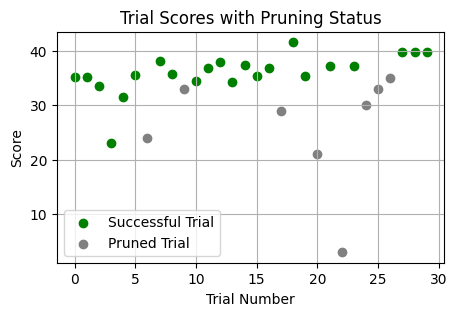

In [7]:
import matplotlib.pyplot as plttrial_logs = compiled_program.trial_logs# 提取试验编号、分数和修剪状态trial_numbers = list(trial_logs.keys())scores = [trial_logs[trial]['score'] for trial in trial_numbers]pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]# 绘图设置plt.figure(figsize=(5, 3))# 绘制每个点for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):    if pruned:        plt.scatter(trial_number, score, color='grey', label='Pruned Trial' if 'Pruned Trial' not in plt.gca().get_legend_handles_labels()[1] else "")    else:        plt.scatter(trial_number, score, color='green', label='Successful Trial' if 'Successful Trial' not in plt.gca().get_legend_handles_labels()[1] else "")plt.xlabel('试验编号')plt.ylabel('分数')plt.title('带有修剪状态的试验分数')plt.grid(True)plt.legend()plt.show()

我们还可以在MIPRO发现的最佳提示随着试验的进行而可视化...（请注意，得分的增加也是由于所选的少样本示例，这些示例在此处未显示以保持简洁）。

In [8]:
best_score = 0# 定义一个函数，用于获取预测器的签名信息def get_signature(predictor):    if (hasattr(predictor, 'extended_signature')):        return predictor.extended_signature    elif (hasattr(predictor, 'signature')):        return predictor.signatureprint(f"Basline program | Score: {best_score}:")# 遍历程序的预测器并输出指令信息for i,predictor in enumerate(program.predictors()):    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")print()print("----------------")# 遍历编译程序的试验日志for trial_num in compiled_program.trial_logs:    program_score = compiled_program.trial_logs[trial_num]["score"]    program_pruned = compiled_program.trial_logs[trial_num]["pruned"]    # 更新最佳分数和最佳程序    if program_score > best_score and not program_pruned:        best_score = program_score        best_program_so_far = compiled_program.trial_logs[trial_num]["program"]    # 每5次试验输出当前最佳程序的指令信息    if trial_num % 5 == 0:        print(f"Best program after {trial_num} trials | Score: {best_score}:")        for i,predictor in enumerate(best_program_so_far.predictors()):            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")        print()

Basline program | Score: 0:
Prompt 1 Instruction: Given the fields `context`, `question`, produce the fields `search_query`.
Prompt 2 Instruction: Given the fields `context`, `question`, produce the fields `answer`.
Prompt 3 Instruction: Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last.

----------------
Best program after 0 trials | Score: 35.2:
Prompt 1 Instruction: Given the fields `context` and `question`, identify the specific information being asked for and produce a concise and accurate response.
Prompt 2 Instruction: Given a fact-based question related to pop culture, history, or entertainment, identify specific works or individuals and provide a concise answer directly corresponding to the question posed.
Prompt 3 Instruction: Given a fact-based que